This notebook is experimenting with two methods of structure optimization: singular value decomposition (SVD) and soft filter pruning (SFP).

The idea of the SVD method is shown in the picture below: the weights of each layer are decomposed into three matrices, then training takes place with additional restrictions on maintaining the orthogonality of the matrices and the sparseness of singular values. After training, the least significant singular numbers and the corresponding rows and columns in orthogonal matrices are pruned. Thus, it is possible to achieve a significant reduction in the number of parameters. During the forward pass, the product of these matrices is calculated, which corresponds to the weight matrix of the original dimension.

![Singular value decomposition](../../docs/img/SVD.png)

The idea of the SVD method is shown in the picture below: after each training epoch, the significance of each filter in the convolutional layer is evaluated, then the least significant filters are set to zero. This procedure is repeated after each training epoch. At the end, unnecessary filters are completely removed from the model.

![Soft filter pruning](../../docs/img/SFP.png)

In [1]:
import sys

sys.path.append('../..')

You can download Land-Use Scene Classification dataset [here](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification).
The first step is to prepare the dataset in the pytorch Dataset format.

In [2]:
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder

dataset_path = '' # your path to dataset

transform = Compose([ToTensor(), Resize((256, 256))])
train_dataset = ImageFolder(root=dataset_path + 'train', transform=transform)
val_dataset = ImageFolder(root=dataset_path + 'validation', transform=transform)

In the cell below, we define the parameters of the experiments to be carried out: an experiment without structure optimization, experiments with a singular value decomposition of convolutional layers, and experiments with soft filter pruning.

If you want to use a pre-trained model, you can set weights parameter like `weights=<your path to state dict>`.

If you don't want to reproduce experiments, you can skip this cell.

In [3]:
import torch

energy_thresholds = [
    0.1, 0.3, 0.5, 0.7, 0.9,
    0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
    0.992, 0.994, 0.996, 0.998, 0.999,
    0.9999, 1
]

exp_params = {
    'dataset_name': 'Land-Use_Scene_Classification',
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'num_classes': 21,
    'dataloader_params': {'batch_size': 32, 'num_workers': 4},
    'model': 'ResNet18',
    'model_params': {},
    'models_saving_path': 'models',
    'optimizer': torch.optim.Adam,
    'optimizer_params': {},
    'target_loss': torch.nn.CrossEntropyLoss,
    'loss_params': {},
    'metric': 'f1',
    'summary_path': 'runs',
    'summary_per_class': True,
    'gpu': True
}

optimizations = {
    'none': [{}],
    'SVD': [
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 1
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 1
        },
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 1
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 1
        },
    ],
    'SFP': [
        {
            'pruning_ratio': 0.5,
            'finetuning_epochs': 1
        },
        {
            'pruning_ratio': 0.7,
            'finetuning_epochs': 1
        },
        {
            'pruning_ratio': 0.8,
            'finetuning_epochs': 1
        },
        {
            'pruning_ratio': 0.9,
            'finetuning_epochs': 1
        },
    ]
}

In the cell below, we run experiments for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")
from fedot_ind.core.architecture.experiment.CVModule import ClassificationExperimenter

for optimization, params_list in optimizations.items():
    for params in params_list:
        experimenter = ClassificationExperimenter(
            structure_optimization=optimization,
            structure_optimization_params=params,
            **exp_params
        )
        experimenter.fit(100)

In the cell below, we optimize the pre-trained model.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")
from fedot_ind.core.architecture.experiment.CVModule import ClassificationExperimenter

experimenter = ClassificationExperimenter(
    structure_optimization='SFP',
    structure_optimization_params={
        'pruning_ratio': 0.5,
        'finetuning_epochs': 10
    },
    weights='models/Land-Use_Scene_Classification/ResNet18/trained_model.sd.pt',
    prefix='without_training_',
    **exp_params
)
experimenter.structure_optimization.optimize_during_training()
experimenter.structure_optimization.final_optimize()

experimenter = ClassificationExperimenter(
    structure_optimization='SVD',
    structure_optimization_params={
        'decomposing_mode': 'channel',
        'orthogonal_loss_factor': 10,
        'hoer_loss_factor': 0,
        'energy_thresholds': energy_thresholds,
        'finetuning_epochs': 3
    },
    weights='models/Land-Use_Scene_Classification/ResNet18/trained_model.sd.pt',
    prefix='without_training_',
    **exp_params
)
experimenter.structure_optimization.final_optimize()

Read results:

In [5]:
import pandas as pd
from visualization_utils import parse_experiment_folder

train_scores, svd_scores_finetuned, svd_scores_pruned, sfp_scores = parse_experiment_folder('runs/Land-Use_Scene_Classification')
for k in ['val/f1', 'val/accuracy', 'train/accuracy']:
    train_scores[k].columns = ['Baseline', 'SFP 50%', 'SFP 70%', 'SFP 80%', 'SFP 90%', 'SVD channel 10', 'SVD channel 100', 'SVD spatial 10', 'SVD spatial 100']

for k, v in sfp_scores.items():
    v.columns = ['SFP 50%', 'SFP 70%', 'SFP 80%', 'SFP 90%', 'SFP optimization 50%']
    v.index = ['baseline', 'pruned', 'fine-tuned']

for k in ['pruning/f1', 'pruning/size']:
    svd_scores_pruned[k].columns = ['SVD channel 10', 'SVD channel 100', 'SVD spatial 10', 'SVD spatial 100', 'SVD optimization (channel)']
    svd_scores_finetuned[k].columns = ['SVD channel 10', 'SVD channel 100', 'SVD spatial 10', 'SVD spatial 100', 'SVD optimization (channel)']

Top models by metrics.

In [8]:
results = pd.DataFrame([train_scores['val/f1'].max(axis=0),
                        train_scores['val/accuracy'].max(axis=0),
                        train_scores['train/accuracy'].max(axis=0)],
                       index=['F1', 'Validation accuracy', 'Train accuracy']
                       ).T.sort_values('F1', ascending=False)
results

,F1,Validation accuracy,Train accuracy
Baseline,0.937292,0.938095,1.000000
SFP 50%,0.932722,0.933333,0.999728
SVD spatial 100,0.923959,0.924286,0.996060
SVD channel 100,0.903336,0.904286,0.993750
SFP 70%,0.901154,0.901429,0.996060
SVD channel 10,0.899932,0.900476,0.985734
SVD spatial 10,0.897342,0.898095,0.988043
SFP 80%,0.874307,0.874286,0.987031
SFP 90%,0.359079,0.390476,0.793021


Run the next cell to visualize the results of the base model, the best sfp model, and the best svd model.

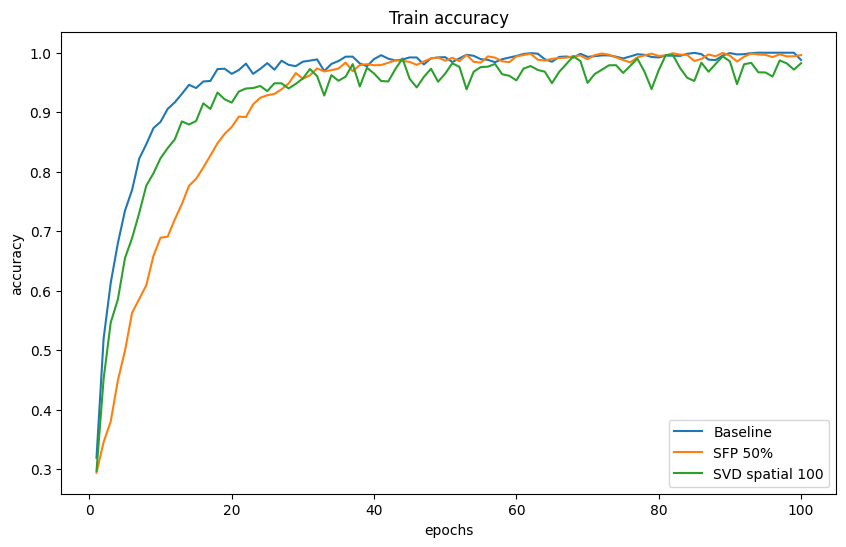

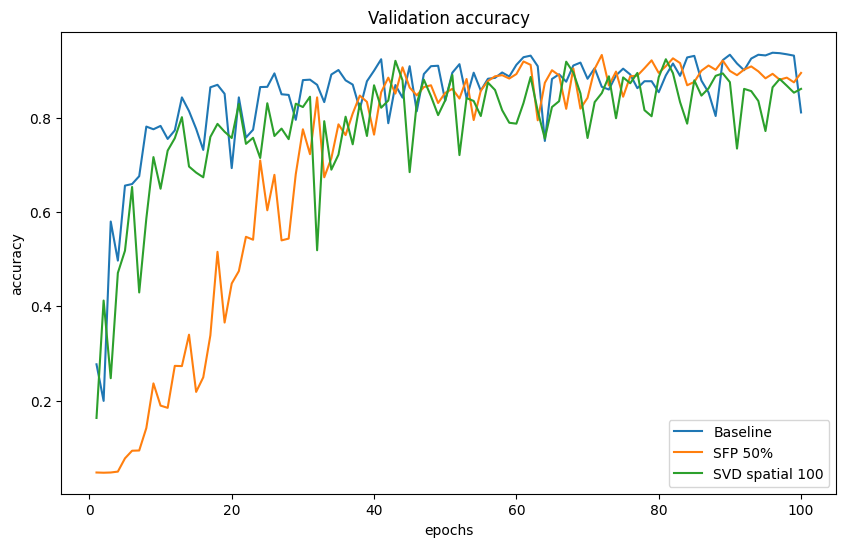

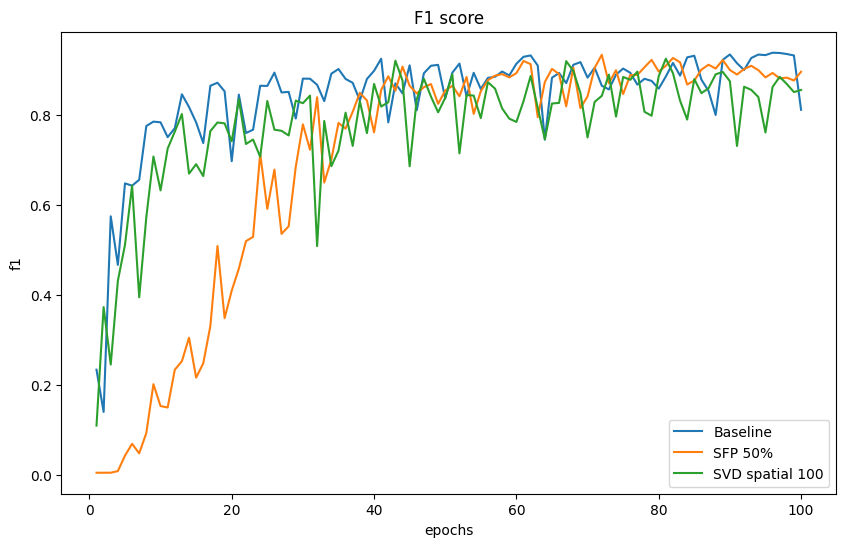

In [6]:
train_scores['train/accuracy'][['Baseline', 'SFP 50%', 'SVD spatial 100']].plot(
    figsize=(10, 6),
    title='Train accuracy',
    xlabel='epochs',
    ylabel='accuracy'
)
train_scores['val/accuracy'][['Baseline', 'SFP 50%', 'SVD spatial 100']].plot(
    figsize=(10, 6),
    title='Validation accuracy',
    xlabel='epochs',
    ylabel='accuracy'
)
train_scores['val/f1'][['Baseline', 'SFP 50%', 'SVD spatial 100']].plot(
    figsize=(10, 6),
    title='F1 score',
    xlabel='epochs',
    ylabel='f1'
);

The table below shows how the values of the SFP model metric change after pruning and fine-tuning.

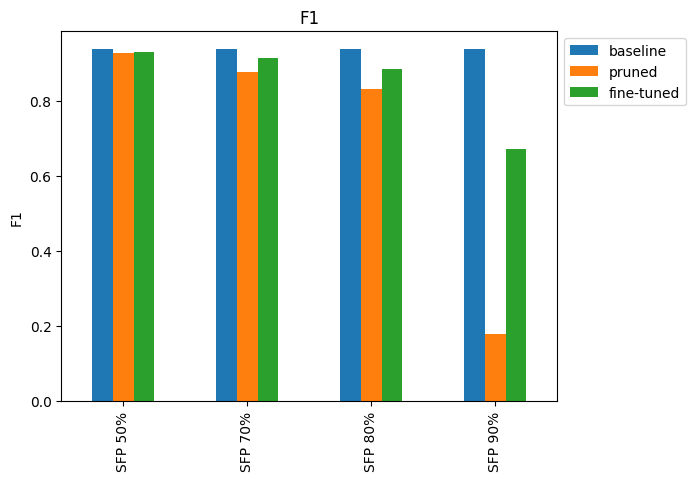

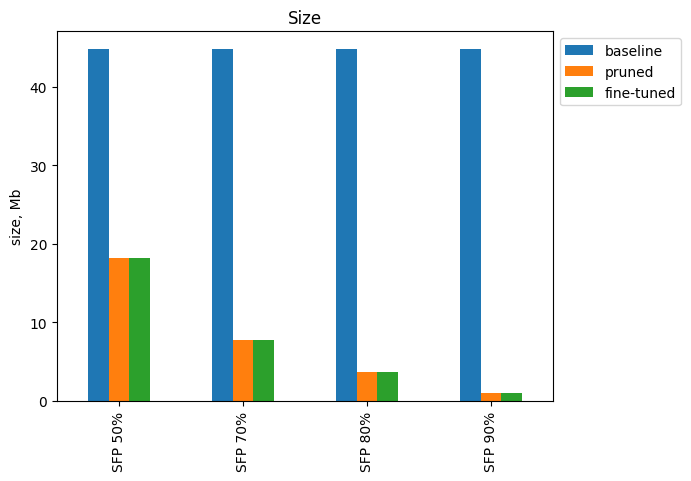

In [9]:
sfp_scores['f1'].loc['baseline'] = results.loc['Baseline', 'F1']
sfp_scores['f1'].iloc[:, :-1].T.plot(kind='bar', title='F1', ylabel='F1').legend(loc='upper left', bbox_to_anchor=(1, 1))
sfp_scores['size'].iloc[:, :-1].T.plot(kind='bar', title='Size', ylabel='size, Mb').legend(loc='upper left', bbox_to_anchor=(1, 1));

In [10]:
baseline_f1 = results.loc['Baseline', 'F1']
baseline_size =  sfp_scores['size'].loc['baseline'].max()

svd_scores_pruned['d_f1'] = (svd_scores_pruned['pruning/f1'] - baseline_f1) / baseline_f1 * 100
svd_scores_pruned['p_size'] = svd_scores_pruned['pruning/size'] / baseline_size * 100
svd_scores_finetuned['d_f1'] = (svd_scores_finetuned['pruning/f1'] - baseline_f1) / baseline_f1 * 100
svd_scores_finetuned['p_size'] = svd_scores_finetuned['pruning/size'] / baseline_size * 100
sfp_scores['d_f1'] = (sfp_scores['f1'] - baseline_f1) / baseline_f1 * 100
sfp_scores['p_size'] = sfp_scores['size'] / baseline_size * 100

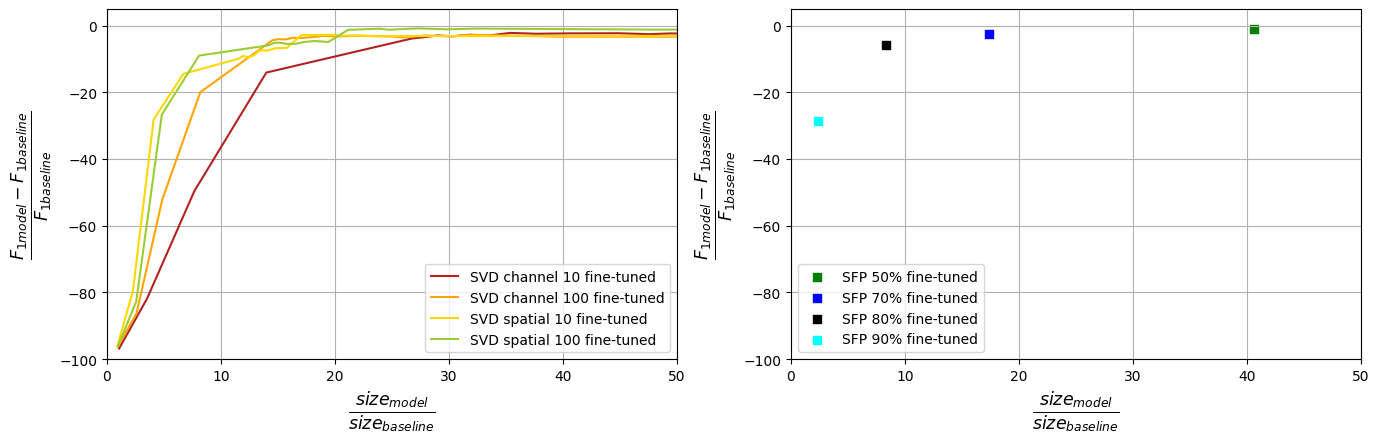

In [11]:
from matplotlib import pyplot as plt
from visualization_utils import plot_scores

plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plot_scores(
    svd_scores_finetuned=(svd_scores_finetuned['p_size'].iloc[:, :-1], svd_scores_finetuned['d_f1'].iloc[:, :-1]),
)
plt.xlabel('$\\frac{size_{model} }{size_{baseline}}$', fontsize=18)
plt.ylabel('$\\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$', fontsize=18)
plt.xlim((0, 50))
plt.ylim((-100, 5));
plt.subplot(2, 3, 2)
plot_scores(
   sfp_scores=(sfp_scores['p_size'].iloc[[2], :-1], sfp_scores['d_f1'].iloc[[2], :-1]),
)
plt.xlabel('$\\frac{size_{model} }{size_{baseline}}$', fontsize=18)
plt.ylabel('$\\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$', fontsize=18)
plt.xlim((0, 50))
plt.ylim((-100, 5));

The graph above shows the results of experiments after fine-tuning the pruned models.

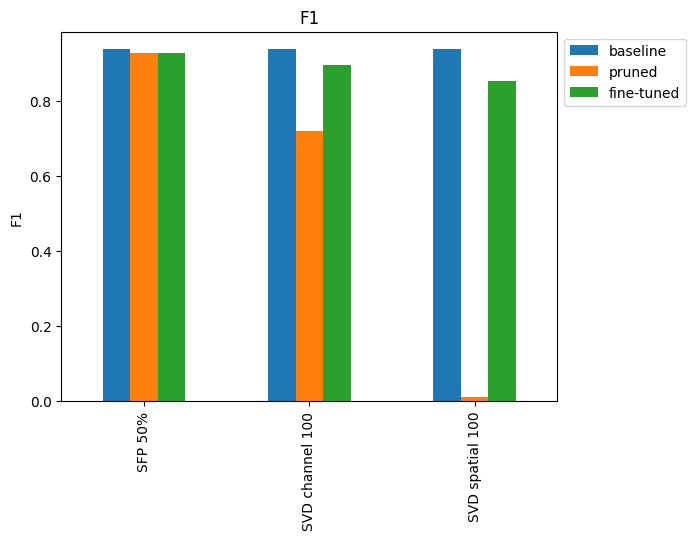

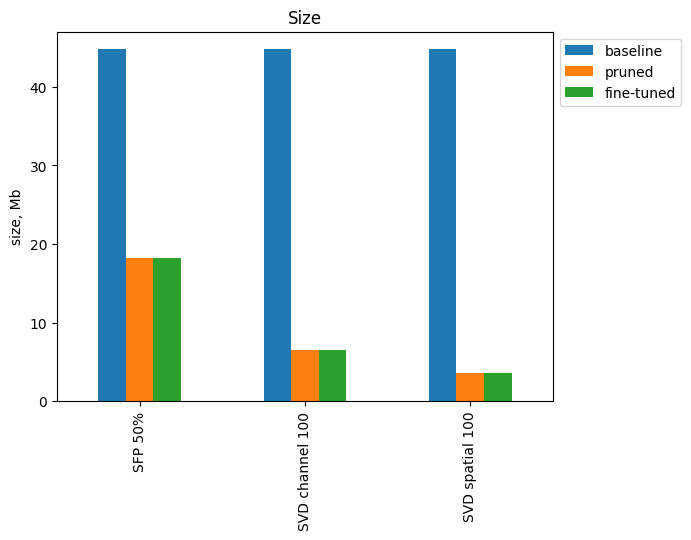

In [12]:
results = svd_scores_finetuned['p_size'] - svd_scores_finetuned['d_f1']
sfp_vs_svd_f1 = sfp_scores['f1'][['SFP 50%', 'SFP optimization 50%']].copy()
sfp_vs_svd_size = sfp_scores['size'][['SFP 50%', 'SFP optimization 50%']].copy()
for col in ['SVD channel 100', 'SVD spatial 100', 'SVD optimization (channel)']:
    sfp_vs_svd_f1.loc['baseline', col] = sfp_vs_svd_f1.loc['baseline', 'SFP 50%']
    sfp_vs_svd_f1.loc['fine-tuned', col] = svd_scores_finetuned['pruning/f1'].loc[results.idxmin()[col], col]
    sfp_vs_svd_f1.loc['pruned', col] = svd_scores_pruned['pruning/f1'].loc[results.idxmin()[col], col]
    sfp_vs_svd_size.loc['baseline', col] = sfp_vs_svd_size.loc['baseline', 'SFP optimization 50%']
    sfp_vs_svd_size.loc['fine-tuned', col] = svd_scores_finetuned['pruning/size'].loc[results.idxmin()[col], col]
    sfp_vs_svd_size.loc['pruned', col] = svd_scores_pruned['pruning/size'].loc[results.idxmin()[col], col]
sfp_vs_svd_f1[['SFP 50%', 'SVD channel 100', 'SVD spatial 100']].T.plot(kind='bar', title='F1', ylabel='F1').legend(loc='upper left', bbox_to_anchor=(1, 1))
sfp_vs_svd_size[['SFP 50%', 'SVD channel 100', 'SVD spatial 100']].T.plot(kind='bar', title='Size', ylabel='size, Mb').legend(loc='upper left', bbox_to_anchor=(1, 1));

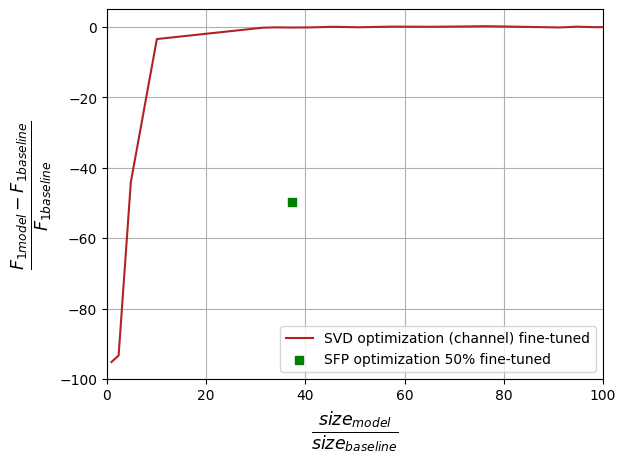

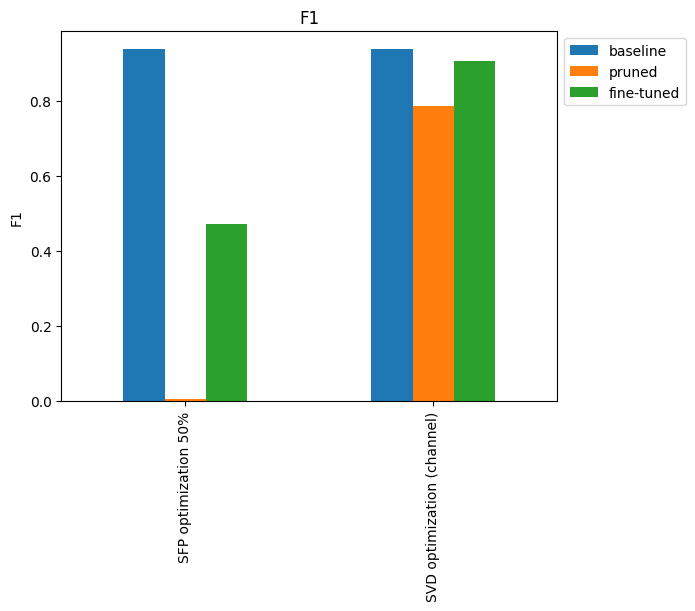

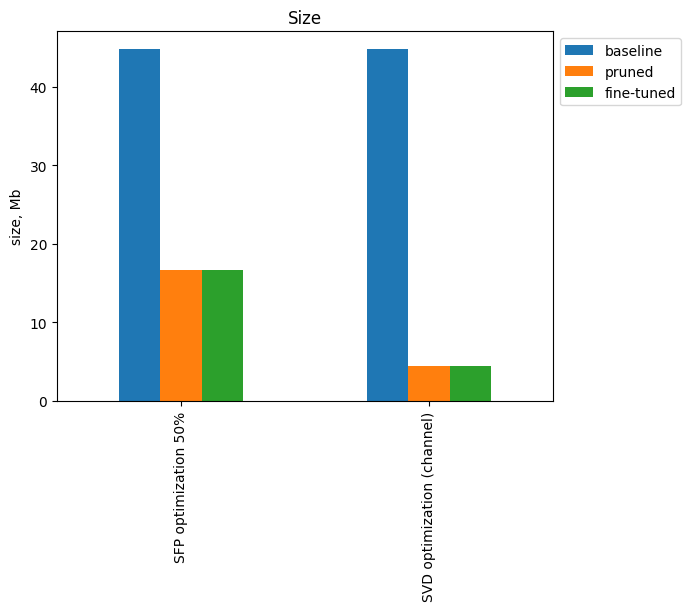

In [13]:
from matplotlib import pyplot as plt
from visualization_utils import plot_scores

plot_scores(
    svd_scores_finetuned=(svd_scores_finetuned['p_size'][['SVD optimization (channel)']], svd_scores_finetuned['d_f1'][['SVD optimization (channel)']]),
    sfp_scores=(sfp_scores['p_size'].loc[['fine-tuned'], ['SFP optimization 50%']], sfp_scores['d_f1'].loc[['fine-tuned'], ['SFP optimization 50%']])
)
plt.xlabel('$\\frac{size_{model} }{size_{baseline}}$', fontsize=18)
plt.ylabel('$\\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$', fontsize=18)
plt.xlim((0, 100))
plt.ylim((-100, 5))
sfp_vs_svd_f1[['SFP optimization 50%', 'SVD optimization (channel)']].T.plot(kind='bar', title='F1', ylabel='F1').legend(loc='upper left', bbox_to_anchor=(1, 1))
sfp_vs_svd_size[['SFP optimization 50%', 'SVD optimization (channel)']].T.plot(kind='bar', title='Size', ylabel='size, Mb').legend(loc='upper left', bbox_to_anchor=(1, 1));

The graph above shows the results of experiments to optimize the structure of the pre-trained model. The SVD approach can be effectively used to reduce the finished model, the SFP method requires preliminary training of the model using this method.

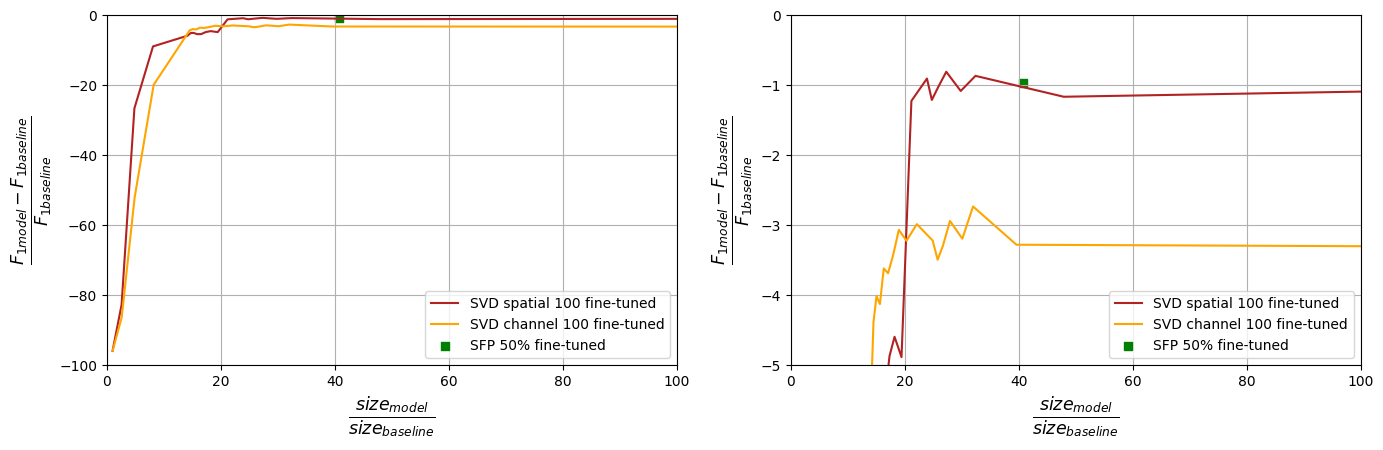

In [14]:
from matplotlib import pyplot as plt
from visualization_utils import plot_scores

plt.figure(figsize=(25, 10))
lim = [(-100, 0), (-5, 0)]
for i in range(2):
    plt.subplot(2, 3, i+1)
    plot_scores(
        svd_scores_finetuned=(svd_scores_finetuned['p_size'][['SVD spatial 100', 'SVD channel 100']], svd_scores_finetuned['d_f1'][['SVD spatial 100', 'SVD channel 100']]),
        sfp_scores=(sfp_scores['p_size'].loc[['fine-tuned'], ['SFP 50%']], sfp_scores['d_f1'].loc[['fine-tuned'], ['SFP 50%']])
    )
    plt.xlabel('$\\frac{size_{model} }{size_{baseline}}$', fontsize=18)
    plt.ylabel('$\\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$', fontsize=18)
    plt.xlim((0, 100))
    plt.ylim(lim[i])
    plt.legend(loc='lower right');

The last graph shows the dependence of the loss in the target metric on the change in the size of the model.

 Models trained using soft filter pruning optimization can be pruned in the only way, models trained using singular value decomposition optimization can be pruned in a variety of ways, so that an acceptable trade-off can be found between loss of recognition quality and model size.

)If you want to use our trained model, you can use the code from the cell below, preloading the weights [here](https://niuitmo-my.sharepoint.com/:f:/g/personal/avlitvintseva_niuitmo_ru/Ein_oioXxvpGgdIHOHc35M0ByA7ILw8-iYo2mjLaeCfpzw?e=BJc6mC).

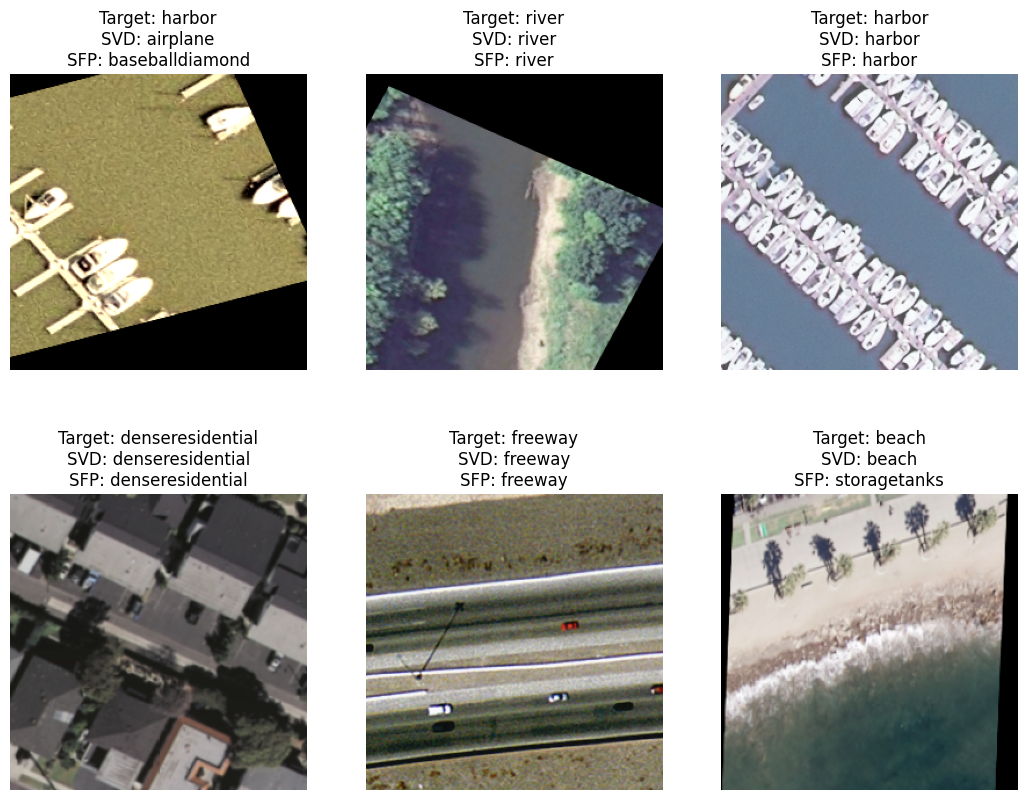

In [16]:
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from fedot_ind.core.operation.optimization.svd_tools import load_svd_state_dict
from fedot_ind.core.operation.optimization.sfp_tools import load_sfp_resnet_model
from matplotlib import pyplot as plt

dl = DataLoader(val_dataset, batch_size=6, shuffle=True)
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

svd_state_dict_path = 'models/Land-Use_Scene_Classification/ResNet18_SVD_spatial_O-100.0_H-0.001000/fine-tuning_e_0.99.sd.pt'
svd_model = resnet18(num_classes=21)
load_svd_state_dict(svd_model, decomposing_mode='channel', state_dict_path=svd_state_dict_path)

sfp_state_dict_path = 'models/Land-Use_Scene_Classification/ResNet18_SFP_P-0.50/fine-tuning.sd.pt'
sfp_model = load_sfp_resnet_model('ResNet18', num_classes=21, state_dict_path=sfp_state_dict_path, pruning_ratio=0.5)


images, targets = next(iter(dl))
svd_preds = svd_model(images)
sfp_preds = sfp_model(images)

plt.figure(figsize=(13, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.title(f'Target: {idx_to_class[targets[i].item()]}\nSVD: {idx_to_class[svd_preds.argmax(1)[i].item()]}\nSFP: {idx_to_class[sfp_preds.argmax(1)[i].item()]}')